In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from statistics import mean 
import cv2
import pickle

In [2]:
# !!!!!!!!!!!!!!!!
#  if you already have saved dfs_splited_isnear_marks skip steps 0-4, make steps 5-8, skip steps 9-10, 
#  continue from the step 11
# !!!!!!!!!!!!!!!!

In [3]:
#0. open preprocessed trajectory data
#паузы исправлены
nam = 'preprocessed_dataset/preprocessed_dfs_subtraj_for_marks.pkl'
with open(nam, 'rb') as fp:
    dfs_dict = pickle.load(fp)

In [ ]:
#откроем словарь 0.3 с чтобы были 0.3 с и сразу смерджим его
with open('preprocessed_dfs_subtraj_0.3s.pkl', 'rb') as fp:
    dfs_03 = pickle.load(fp)

# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has V=0
merg_dfs_03 = {}

for k, df in dfs_03.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_dfs_03[k] = pd.concat(df)
    merg_dfs_03[k] = merg_dfs_03[k].reset_index(drop=True)

<Figure size 640x480 with 0 Axes>

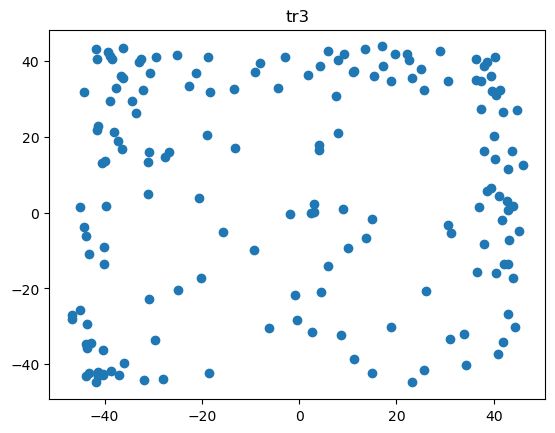

<Figure size 640x480 with 0 Axes>

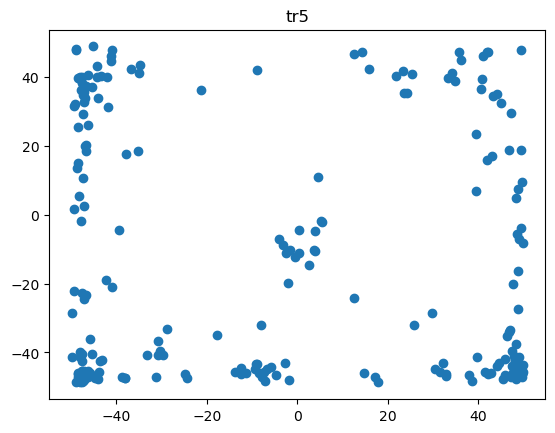

<Figure size 640x480 with 0 Axes>

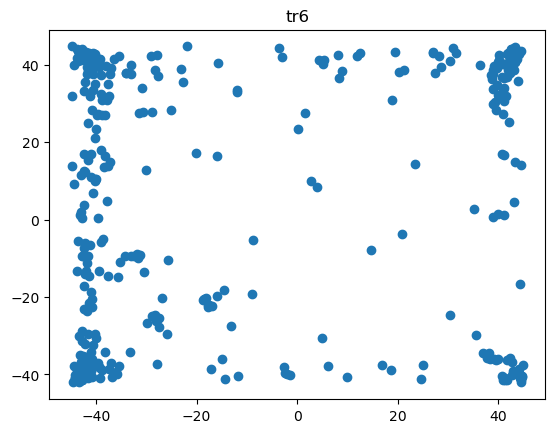

<Figure size 640x480 with 0 Axes>

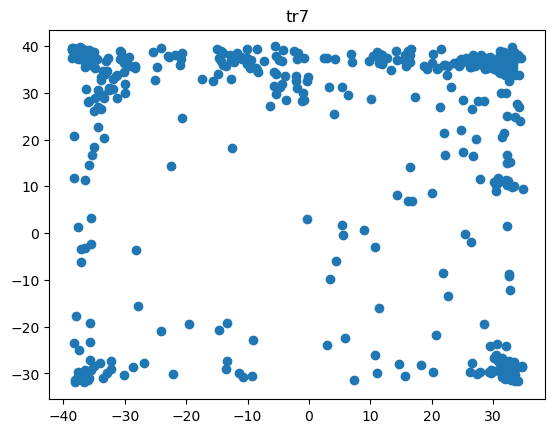

In [451]:
#графики остановок старого кода
# for i in range(len(names)):
#     plt.figure()
#     plotPauses(dfs[i])
#     plt.title(names[i])

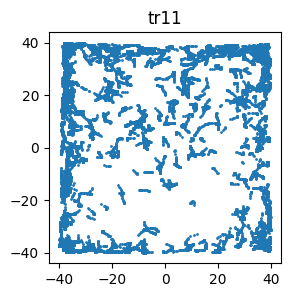

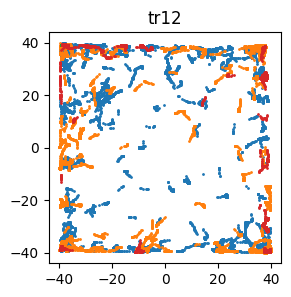

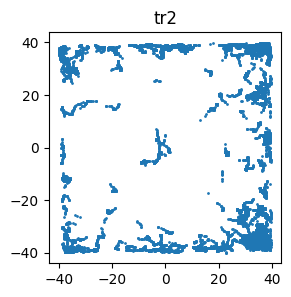

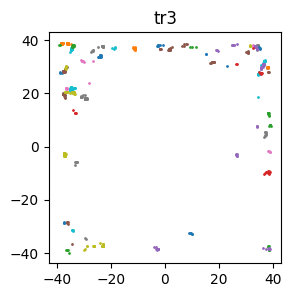

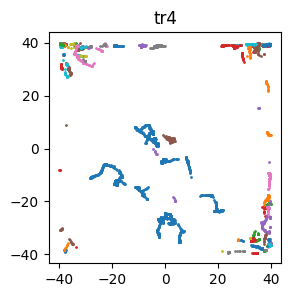

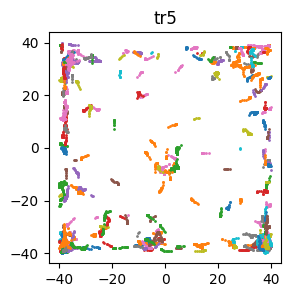

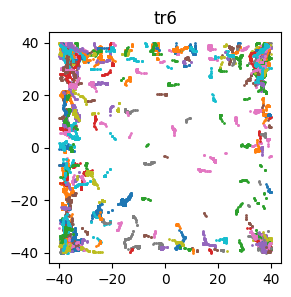

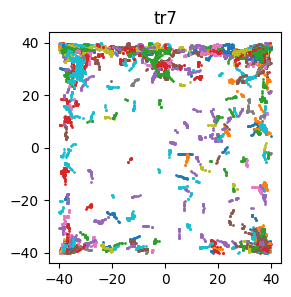

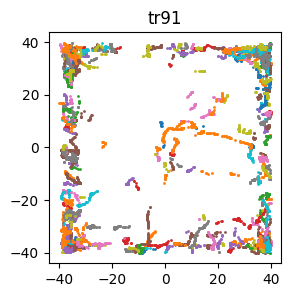

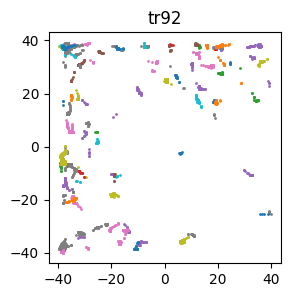

In [5]:
# (optional) 1. нарисуем точки, в которых мышь останавливалась
for k, df in dfs_dict.items():
    plt.figure(figsize=(3, 3))
    plt.title(k)
    for ldf in df:
        n_ldf = ldf.loc[ldf['movement']=='Stop']
        plt.scatter(n_ldf['x'], n_ldf['y'], s=1)
    plt.show()

In [6]:
#2. добавим в словарь фильтрованную скорость
def add_filtered_V(df, smooth_kern=2):
    dt = df['time'].diff()
    vx = df['x'].diff() / dt
    vy = df['y'].diff() / dt
    v = (vx**2 + vy**2)**0.5

    dt[0], vx[0], vy[0] = 0., 0., 0.
    v[0] = 0.
    df['Vx'] = gaussian_filter1d(vx, smooth_kern)  # TODO: why smoothing?
    df['Vy'] = gaussian_filter1d(vy, smooth_kern)
    df['V'] = gaussian_filter1d(v, smooth_kern)

    df.loc[0, 'Vx'] = 0.
    df.loc[0, 'Vy'] = 0.
    df.loc[0, 'V'] = 0.
    return df

for k, df in dfs_dict.items():
    sub_list = []
    i = 0
    for ldf in df:
        ldf = ldf.reset_index(drop=True)
        ldf = add_filtered_V(ldf)
        sub_list.append(ldf)
    dfs_dict[k] = sub_list

In [7]:
#3. merge dfs of 1 mouse

# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has V=0
merg_dfs_dict = {}

for k, df in dfs_dict.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_dfs_dict[k] = pd.concat(df)
    merg_dfs_dict[k] = merg_dfs_dict[k].reset_index(drop=True)

In [8]:
##4. split the table by time
start_end = {
'tr3': [1.268, 1567.099],
'tr5': [1.068, 1754.786],
'tr6': [1.068, 1662.261],
'tr7': [1.068, 1635.601],
'tr91': [1.068, 1463],
'tr92': [1.068, 645] }
#некоторые мыши (91, 92) под конец записи сидят на 1 месте
#может лучше в словарь запихнуть только используемых мышей

used_mice = ['tr3','tr5','tr6','tr7','tr91']

def cut_df(df_to_cut, n_of_parts, t1, t2):
    dur_of_part = (t2 - t1) / n_of_parts
    parts = []
    for i in range(n_of_parts):
        t1_local = t1 + dur_of_part * i
        t2_local = t1 + dur_of_part * (i+1)
        part_df = df_to_cut.loc[(df_to_cut['time'] > t1_local) & (df_to_cut['time'] < t2_local)]
        parts.append(part_df)
    return parts

In [9]:
n_to_split = 3
splited_dfs = {}
for m in used_mice:
    splited_dfs[m] = cut_df(merg_dfs_dict[m], n_to_split,
                            start_end[m][0], start_end[m][1])

### строим метки

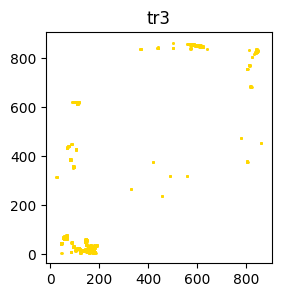

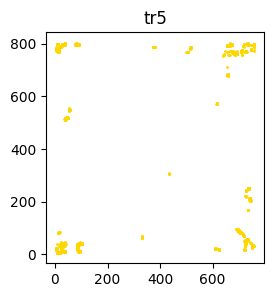

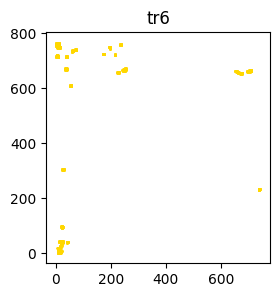

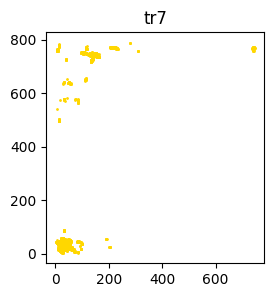

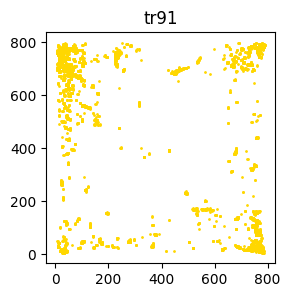

In [10]:
#5 из считанной картинки с метками делаем таблицу с координатами помеченных пикселей
#теперь метки сразу расположены правильно, как и траектории
def RedDFFromIm(im, k=''):
    coords = []
    #так, я поменяла местами х и у и соответсвенно хмакс умакс
    #вернула как было
    xmax = im.shape[0]
    ymax = im.shape[1]
    for i in range(len(im)):
        for j in range(len(im[i])):
            if (int(im[i][j][2]) - int(im[i][j][0]) > 15) and (int(im[i][j][2]) - int(im[i][j][0]) > 15):
                coords.append([i,j,im[i][j][2],im[i][j][1],im[i][j][0]])
    df = pd.DataFrame(coords, columns =['y', 'x', 'red', 'green', 'blue'])
    fig, ax = plt.subplots(figsize=(3, 3))
    #ax.set_xlim(xmax)
    #ax.set_ylim(ymax)
    ax.set_aspect('equal', adjustable='box')
    plt.title(k)
    plt.plot(df['x'], df['y'],'o', markersize=1, color='gold')
    plt.show()
    marks = {'df':df, 'xmax':xmax, 'ymax':ymax}
    return(marks)

IMG_DIR = 'marks_orig_pictures'
marks = {}
used_mice = ['tr3','tr5','tr6','tr7','tr91']  # 'tr92'
img_names = ['mark_3', 'mark_5', 'mark_6', 'mark_7', 'mark_9.1',]  # 'mark_9.2'

for tr_nam, img_nam in zip(used_mice, img_names):
    im = cv2.imread(f"{IMG_DIR}/{img_nam}.png")
    marks[tr_nam] = RedDFFromIm(im, tr_nam)

In [11]:
from utils.processing import rescale_coord

# 6. переводим метки и траектории в 1 координаты
rescaled_marks = {}
AREA_SIZE = [-40, 40]
for k, df in marks.items():
    rescaled_x = rescale_coord(df['df']['x'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['df']['y'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    df_ = pd.DataFrame({'x': rescaled_x, 'y': rescaled_y})
    rescaled_marks[k] = df_

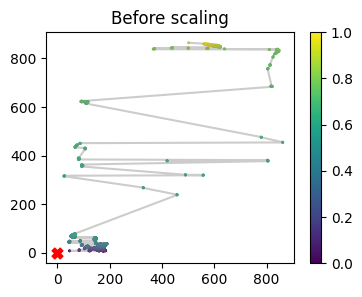

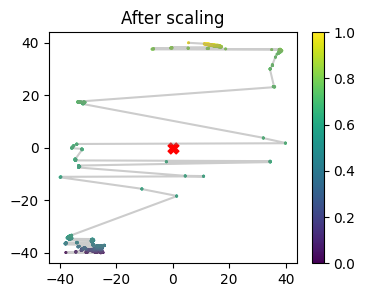

In [12]:
from utils.plotting import plot_trajectory

plt.figure(figsize=(4, 3))
plt.title('Before scaling')
plot_trajectory(marks['tr3']['df']['x'],
                marks['tr3']['df']['y'])

plt.figure(figsize=(4, 3))
plt.title('After scaling')
plot_trajectory(rescaled_marks['tr3']['x'],
                rescaled_marks['tr3']['y'])

Text(0.5, 1.0, 'tr3')

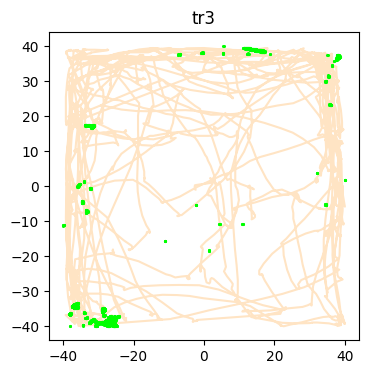

In [13]:
#вроде так верно
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_marks['tr3']['x'], rescaled_marks['tr3']['y'],
            c='lime', s=1.5, zorder=1)
plt.plot(merg_dfs_dict['tr3']['x'], merg_dfs_dict['tr3']['y'],
         c='bisque', zorder=0)
plt.title('tr3')

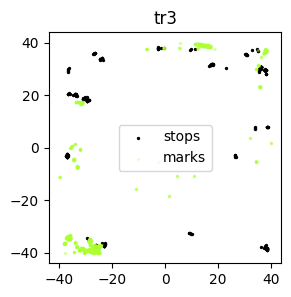

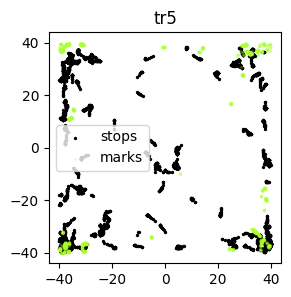

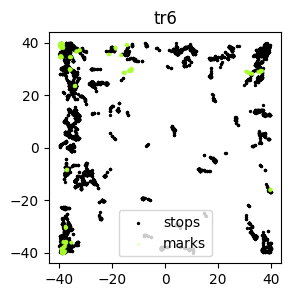

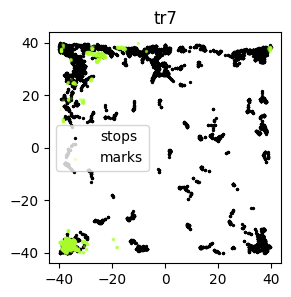

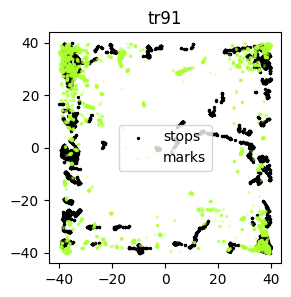

In [14]:
#метки и остановки  # TODO: correct rotation?
for k, df_n in splited_dfs.items():
    df = df_n[2]  # take the last 1/3 part
    df_stop = df.loc[df['movement']=='Stop']
    plt.figure(figsize=(3, 3))
    plt.scatter(df_stop['x'], df_stop['y'], c='k', s=2,
                label='stops')
    plt.scatter(rescaled_marks[k]['x'],
                rescaled_marks[k]['y'],
                c='greenyellow', alpha=0.2, s=2,
                label='marks')
    plt.title(k)
    plt.legend()
    plt.show()

In [15]:
def df_minmax(occ):
    if isinstance(occ, pd.DataFrame):
        occ = occ.to_numpy()
    kk = (occ - np.amin(occ)) / (np.amax(occ) - np.amin(occ))
    kl = pd.DataFrame(kk)
    return kl

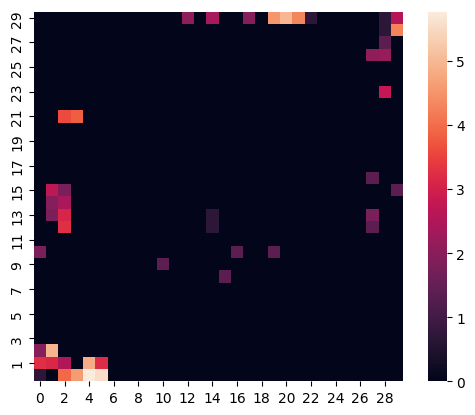

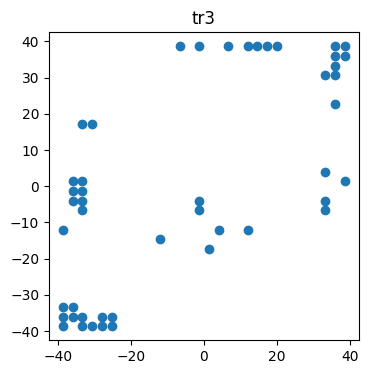

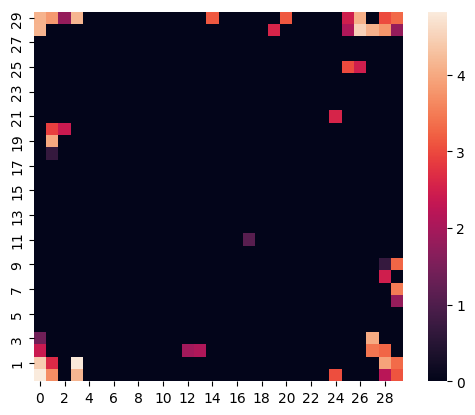

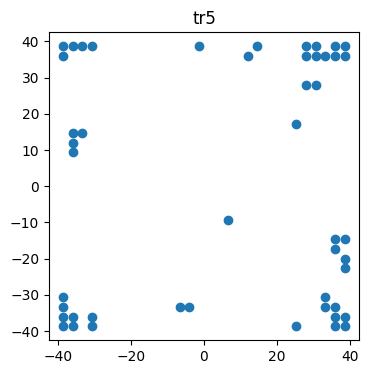

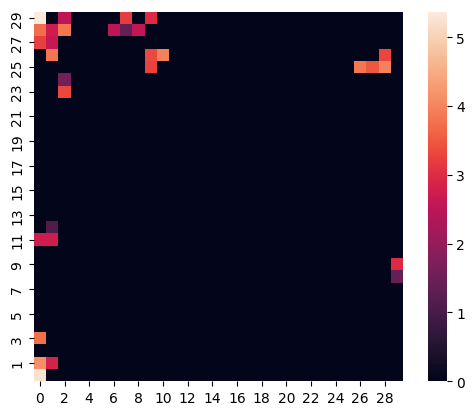

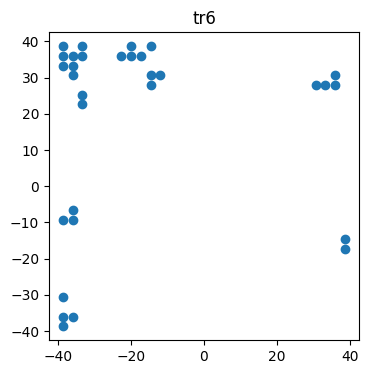

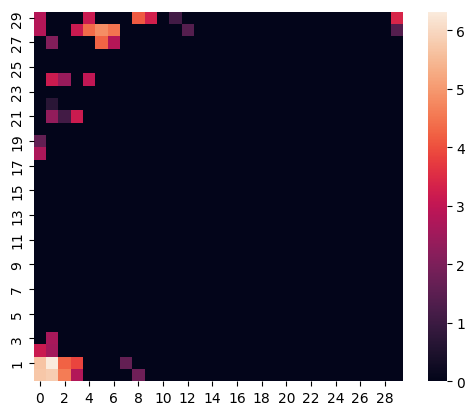

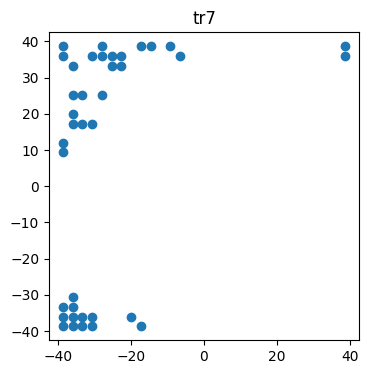

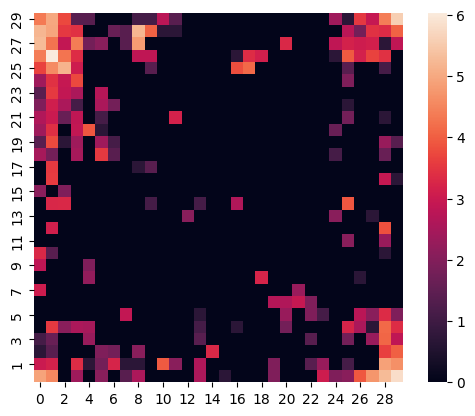

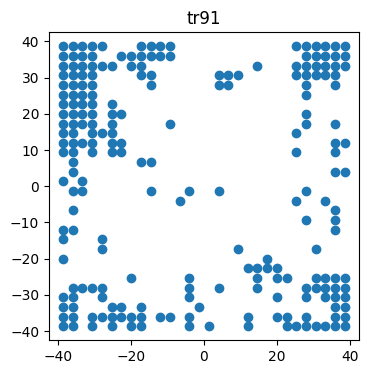

In [55]:
#7 функция окууп карта меток dfHM
#parameter to change!!!!! n
# тут, может есть лишние вращения, но изначально (до этого шага) и в результате этого шага все расположено правильно, 
# в единой системе координат
#поч немного поменялось расположение меток, наверное, были смещены границы/бины

METKA_THRESH = 0.4
BINN = 30
SCALING = 'log'

def make_occup_map(df, n=20, eps=1e-3, scaling='sqrt', show=True):
    """
    на вход нужна таблица с time x y 
    """
    binx = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    x_cut = pd.cut(df['x'], binx, right=False)
    biny = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    y_cut = pd.cut(df['y'], biny, right=False)
    
    dfn = df.groupby([x_cut, y_cut], observed=False).count()
    dfn = dfn.drop(columns=['x', 'y'])

    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))

    dd = dfm.unstack()
    if scaling=='sqrt':
        arrd = dd.replace(0, 1e-2).to_numpy()
        arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    elif scaling=='log':
        arrd = dd.replace(0, 1).to_numpy()
        arrsrsr = np.log(arrd)
    elif scaling==None:
        arrd = dd.replace(0, 1e-2).to_numpy()
        arrsrsr = arrd
         
    kk = pd.DataFrame(arrsrsr)
    kk = kk.transpose()
    kk = kk.iloc[::-1]  # rotate occupancy map
    if show:
        sns.heatmap(kk, square=True)
    return kk, binx, biny

#8 делаем координаты новых "меток" - центров квадратов, в которых достаточно много меток
def heat_maps_with_coords(marksN, tit='', show=True):
    
    # 1. build occupation (heat) map of marks
    dfHM, binx, biny = make_occup_map(marksN, n=BINN, scaling='log') 
    
    # 2. occ map in which indices are coordinates
    binxmid, binymid = [], []
    for i in range(1, len(binx)):
        binxmid.append((binx[i] + binx[i-1]) / 2)
        binymid.append((biny[i] + biny[i-1]) / 2)
    dfHM.index = binxmid[::-1]
    dfHM.columns = binymid

    # 3. take coordinates of cells with sufficient amount of urine marks 
    # вытащим координаты квадратов где довольно много меток
    # координаты меток т.е. i это y (row) а j это x (column)
    # parameter to change 0.3
    trN_coords, trN_coeff = [], []
    for i in range(dfHM.shape[0]-1, -1, -1):
        for j in range(dfHM.shape[1]):
            if dfHM.iloc[i, j] > METKA_THRESH:
                trN_coords.append((dfHM.columns[j], dfHM.index[i]))
                trN_coeff.append((dfHM.iloc[i, j]))
    if show:
        plt.figure(figsize=(4, 4))
        trN_coords_x = [i[0] for i in trN_coords]
        trN_coords_y = [i[1] for i in trN_coords]
        plt.scatter(trN_coords_x, trN_coords_y)
        plt.title(tit)
        plt.show()

    return trN_coords, trN_coeff

hm_marks_coords = {}
hm_marks_coeff = {}
for n in used_mice:
    df = rescaled_marks[n]
    df['c'] = np.ones((rescaled_marks[n].shape[0])) # instead of time

    marks_coords, mark_coeff = heat_maps_with_coords(df, tit=n)
    hm_marks_coords[n] = marks_coords
    hm_marks_coeff[n] = mark_coeff

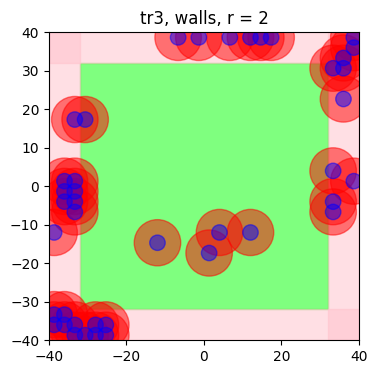

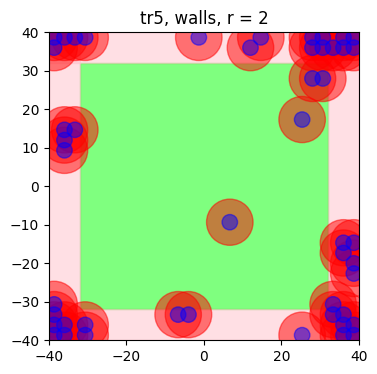

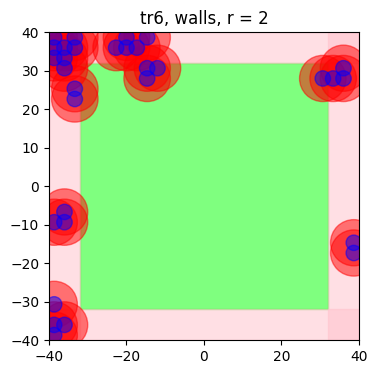

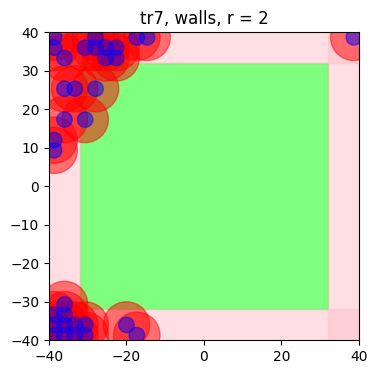

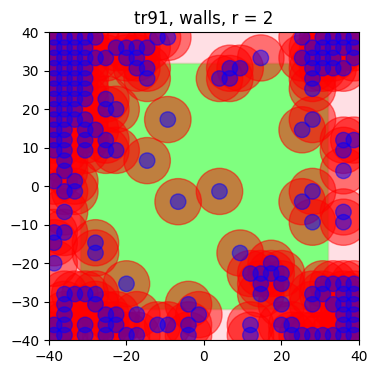

In [17]:
#9. (additional) make pictures to compare areas of marks surroundings vs regular space
r1 = 2
r2 = 3 * r1

for n in used_mice:
    fig, ax = plt.subplots(figsize=(4, 4))
    square = Rectangle((-32, -32), 64, 64, color=(0, 1, 0),
                           alpha=0.5)
    ax.add_patch(square)

    squares = [Rectangle((-40, -40), 8, 80),
               Rectangle((32, -40), 8, 80),
               Rectangle((-40, -40), 80, 8),
               Rectangle((-40, 32), 80, 8)]
    sq = PatchCollection(squares, alpha=0.5, color='pink')
    ax.add_collection(sq)

    # TODO: add corners
    
    for r, col in zip([r2, r1], ['red', 'blue']):
        patches = []
        coords = hm_marks_coords[n]
        for c in coords:
            circle = Circle((c[0], c[1]), r)
            patches.append(circle)
        p = PatchCollection(patches, color=col, alpha=0.5)
        ax.add_collection(p)

    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    name = n + ', walls' + ', r = ' + str(r)
    plt.title(name)
    plt.show()
    # break

In [18]:
#10. размечаем в таблице траектории какие точки находятся в окрестностях r1 и r2 меток, а какие нет
def calc_marks_masks(trN, trN_marks_coords, r1=2, r2=6):
    trN_marks_coords = np.asarray(trN_marks_coords)
    x_metki = trN_marks_coords[:, 0][..., np.newaxis]
    y_metki = trN_marks_coords[:, 1][..., np.newaxis]

    xm = np.tile(trN['x'].values, (x_metki.shape[0], 1))
    ym = np.tile(trN['y'].values, (y_metki.shape[0], 1))

    # shape: [num_metki, num_points]
    dist = ((xm - x_metki)**2 + (ym - y_metki)**2)**0.5  
    mask_r1 = dist <= r1
    mask_r2 = dist <= r2

    # plt.figure(figsize=(14, 10))  # TODO: you can look at the timeline
    # plt.imshow(mask_r1*1)
    # plt.show()
    # plt.figure(figsize=(14, 10))
    # plt.imshow(mask_r2*1)
    # plt.show()

    return mask_r1, mask_r2

def add_marks_intersect_times(df, m_r1, m_r2):
    """ 
    adds to df 2 columns: 'r1' and 'r2'
    calculate if a time point in ANY mark
    sum up all intersected marks, so add duplicate in marks clusters
    """
    counts_r1 = np.sum(m_r1*1, axis=0)
    counts_r2 = np.sum(m_r2*1, axis=0)
    # print(np.unique(counts_r1, return_counts=True)) # TODO: u can look at uniqe vals
    # print(np.unique(counts_r2, return_counts=True))
    df_ = df.copy()
    df_['r1'] = counts_r1
    df_['r2'] = counts_r2
    return df_


dfs_splited_isnear_marks = {}
for m in used_mice:
    subtraj_list = []
    for df in splited_dfs[m]:
        m_r1, m_r2 = calc_marks_masks(df, hm_marks_coords[m], r1=2, r2=6)
        subtraj_list.append(add_marks_intersect_times(df, m_r1, m_r2))
        dfs_splited_isnear_marks[m] = subtraj_list
        # break
    # break

In [ ]:
# TODO: KATE: 5. create super clusters from metki, 
#       from occup map calc a coeff of strengh of this this super cluster
#       is there some correlation between parameters of mouse and strengh of metkas?
# TODO: 3. просто коэффициент сколько меток по сравнению с общей площадью (в бинах). 
#       N metki bins / N all bins - for each mouse
# TODO: 4. distribure metki in 3 types of areas (corners, walls, center)

# TODO: как статистически доказать что мышь возле стен и мышь возле меток+стен различаются?
#       какие данные брать?
#       1. cравнивать у мышей tr3, tr6, tr7 стены с метками и без (все сэмплы) 
#       по скорости, occupancy, остановкам, 
#              частоту пересечения (the first passage time ??)


# ANALYSIS:
# TODO: is there some difference between parameters of mouse and 3 types of metkas?
# TODO: KATE: 2. plot vector field + metki, occup map + metki
# TODO: frequency of visiting metki (compare with any point in the same area type, e.g. wall)
# TODO: tr3, tr6, tr7 - есть углы без меток?

# TODO: hyperparameters: metki theshhold=0.3, r1, r1, bin of open area, 
# TODO: all the same but for 3 time parts of mouse in the field
# TODO: can we see difference in 1st and 3rd part of recording?

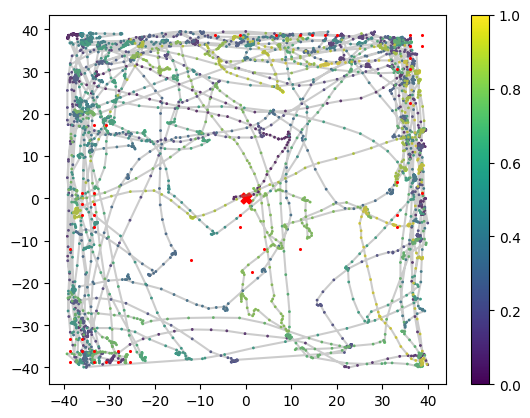

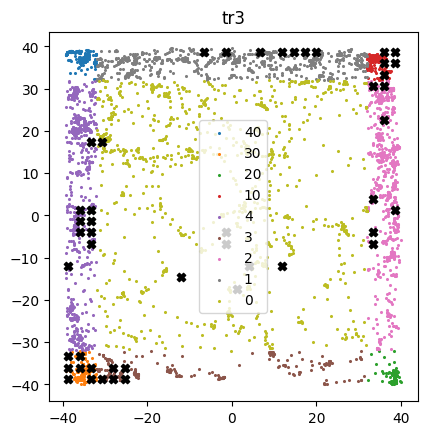

In [47]:
k = 'tr3'

tr1 = pd.concat(dfs_splited_isnear_marks[k])

# for i in range(3):
#     tr1 = dfs_splited_isnear_marks[k][i]

    # Real marks
    # plt.scatter(rescaled_marks[k]['x'], rescaled_marks[k]['y'],
    #     c='blue', s=1.5, zorder=1)

marks_coords = hm_marks_coords[k] 
mark_coeff = hm_marks_coeff[k] 

m = marks_coords
m = np.asarray(m)
plt.scatter(m[:, 0], m[:, 1], c='red', s=1.5, zorder=27)

plot_trajectory(tr1['x'], tr1['y'])

from utils.plotting import plot_wall_sorted_samples
plt.scatter(m[:, 0], m[:, 1], c='black', zorder=2, marker='X')
plot_wall_sorted_samples(tr1, k)
#     break

In [178]:
from sklearn.cluster import DBSCAN

def cluster_marks(marks_coords, eps=4, min_samples=1,
                  show=False):
    X = np.asarray(marks_coords)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ = list(labels).count(-1)

    if show:
        plt.figure(figsize=(6, 6))
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]  # black used for noise
            class_member_mask = (labels == k)
            xy = X[class_member_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                    markeredgecolor='k', markersize=14)
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
    
    return labels

In [183]:
MARKS_DIR = 'preprocessed_dataset'
clust_params = {
        'tr3': {'eps': 7, 'min_samples': 1},
        'tr5': {'eps': 5, 'min_samples': 1},
        'tr6': {'eps': 4, 'min_samples': 1},
        'tr7': {'eps': 7, 'min_samples': 1},
        'tr91': {'eps': 5, 'min_samples': 3},
               }

clustered_marks = {}

for k in hm_marks_coords.keys():
    cparams = clust_params[k]
    marks_coords = hm_marks_coords[k] 
    mark_coeff = hm_marks_coeff[k]   # ~occup map

    lab = cluster_marks(marks_coords,
                        eps=cparams['eps'],
                        min_samples=cparams['min_samples'],
                        show=False)
    X = np.asarray(marks_coords)
    df_marks = pd.DataFrame(data={'x': X[:, 0],
                                'y': X[:, 1],
                                'coeff': mark_coeff,
                                'cluster': lab})
    clustered_marks[k] = df_marks
    
    savename = f'{MARKS_DIR}/marks_{k}_{BINN}bin_{SCALING}.pkl'
    with open(savename, 'wb') as fp:    
        pickle.dump(df_marks, fp)

In [181]:
df_marks

,x,y,coeff,cluster
0,-38.667633,-38.667633,4.927254,0
1,-36.000900,-38.667633,4.532599,0
2,-30.667433,-38.667633,2.397895,0
3,-25.333967,-38.667633,2.079442,0
4,-20.000500,-38.667633,1.386294,0
...,...,...,...,...
215,28.000700,38.667633,0.693147,10
216,30.667433,38.667633,3.526361,10
217,33.334167,38.667633,2.944439,10
218,36.000900,38.667633,4.394449,10


In [155]:
# to df, save with binn info, scaling type
# name = f'{BINN}_{SCALING}.'
# with open('preprocessed_dataset/splited_isnear_marks.pkl', 'wb') as fp:    
#     pickle.dump(dfs_splited_isnear_marks, fp)

In [ ]:
# for tr3
# tr_30 = tr1.loc[(tr1['x'] <= -22) & (tr1['y'] <= -25)]
# tr_20 = tr1.loc[(tr1['x'] >= 22) & (tr1['y'] <= -25)]
# print(tr_30.shape, tr_20.shape)

# tr_10 = tr1.loc[(tr1['x'] >= 22) & (tr1['y'] >= 25)]
# tr_40 = tr1.loc[(tr1['x'] <= -22) & (tr1['y'] >= 25)]

# for tr7
# ...

# for 6
# ...

(2422, 13) (4656, 13)


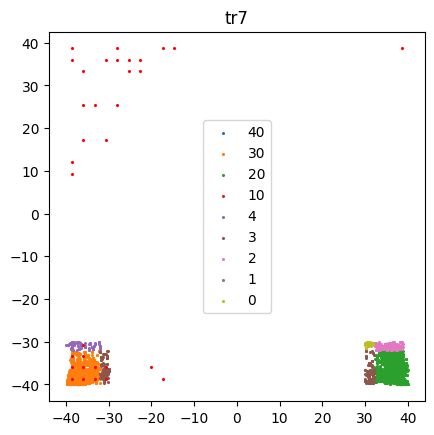

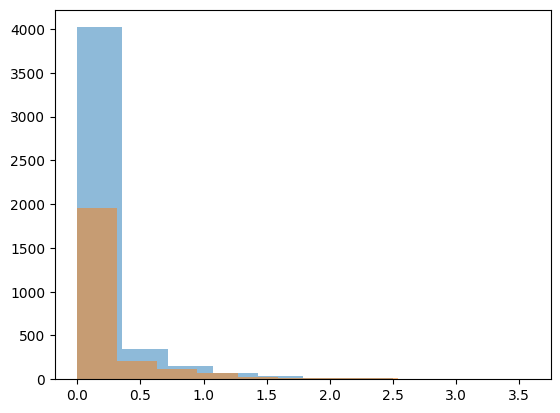

,index,time,x,y,step_length,near_wall,step_sum_0.5,movement,Vx,Vy,V,r1,r2
5527,102,186.887,-31.040809,-39.350299,1.923157,3.0,10.678552,Move,-21.193259,-4.588837,22.371428,1,6
5528,103,186.920,-31.040809,-39.350299,0.000000,3.0,10.497775,Move,-20.782413,-4.974627,21.837715,1,6
5529,104,186.953,-31.040809,-39.350299,0.000000,3.0,10.416563,Move,-21.200792,-4.429394,21.992146,1,6
5530,105,186.987,-32.943319,-39.675149,1.930045,30.0,10.758380,Move,-22.363096,-3.447350,22.873110,1,7
5531,106,187.020,-32.943319,-39.675149,0.000000,30.0,10.758380,Move,-23.170919,-2.449925,23.470166,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42505,44,1531.563,-31.912702,-33.589765,1.545390,3.0,7.526020,Move,16.149201,16.118068,23.037873,0,7
42506,45,1531.597,-31.912702,-33.589765,0.000000,3.0,7.526020,Move,15.775608,16.585997,23.025548,0,7
42507,46,1531.630,-31.199533,-32.778751,1.079979,3.0,8.492448,Move,16.088661,17.105583,23.562955,0,6
42508,47,1531.663,-31.199533,-32.778751,0.000000,3.0,8.492448,Move,17.572941,18.526538,25.590172,0,6


In [112]:
# 1. assign groups to metki

tr_30 = tr1.loc[(tr1['x'] <= -30) & (tr1['y'] <= -30)]
tr_20 = tr1.loc[(tr1['x'] >= 30) & (tr1['y'] <= -30)]
print(tr_30.shape, tr_20.shape)

# tr_10 = tr1.loc[(tr1['x'] >= 22) & (tr1['y'] >= 25)]
# tr_40 = tr1.loc[(tr1['x'] <= -22) & (tr1['y'] >= 25)]
# print(tr_10.shape, tr_40.shape)

plt.scatter(m[:, 0], m[:, 1], c='red', s=1.5, zorder=2)

plot_wall_sorted_samples(pd.concat([tr_30, tr_20]), k)
# plot_wall_sorted_samples(pd.concat([tr_10, tr_40]), k)

# plt.hist(tr_20['step_length'], alpha=0.5)
# plt.hist(tr_30['step_length'], alpha=0.5)
# plt.show()

plt.hist(tr_20['step_length'], alpha=0.5)
plt.hist(tr_30['step_length'], alpha=0.5)
plt.show()
tr_30


In [104]:
# How to check stats in case when we have disproportion in the number of samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
import numpy as np
from scipy.stats import mannwhitneyu

# n1 = np.random.normal(0, 1, size=(500, ))
# n2 = np.random.normal(1, 1, size=(100, ))
n1 = tr_20['step_length'].to_numpy()
n2 = tr_30['step_length'].to_numpy()
print(n1.shape, n2.shape)

U1, p = mannwhitneyu(n1, n2,)
print(U1, p)

(5364,) (3210,)
8647728.5 0.7189407594474158


In [25]:
# Save distributions
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'wb') as fp:    
    pickle.dump(dfs_splited_isnear_marks, fp)

In [22]:
#11. open dfs_splited_isnear_marks if we skipped steps 0-4, 9-10
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'rb') as fp:
    dfs_splited_isnear_marks = pickle.load(fp)

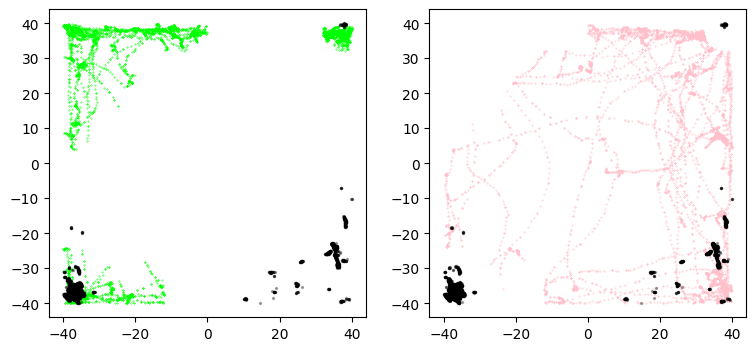

In [26]:
#check surrounding of marks
df = dfs_splited_isnear_marks['tr7'][0]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
check = df.loc[(df['r2']>0) & (df['r1']>=0)]
ax[0].scatter(check['x'], check['y'], s=0.1, c='lime')
ax[0].scatter(rescaled_marks['tr7']['y'],
              rescaled_marks['tr7']['x'], s=2, c='black', alpha=0.3)

check1 = df.loc[(df['r2']==0) & (df['r1']==0)]
ax[1].scatter(check1['x'], check1['y'], s=0.1, c='pink')
ax[1].scatter(rescaled_marks['tr7']['y'],
              rescaled_marks['tr7']['x'],s=2, c='black', alpha=0.3)
plt.show()

In [23]:
# 12. compare navigation parameters between marks surroundings and the remaining area

In [27]:
#make df with percent of samples, percent of pauses, velocities in marks surroundings and the remaining area
#walls
navig_pars_walls = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]
        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n],
                                 'time_part':[i+1, i+1, i+1],
                                 'near_mark':['r1','r2','0'], 
                                 'near_wall/near_wall':['near_wall','near_wall','near_wall'], 
                                 'percent_of_samp':[m1, m2, m3],
                                 'pers_of_pause': [p1, p2, p3],
                                 'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
                                 'all_v':[vv1, vv2, vv3],
                                 })
        navig_pars_walls = pd.concat([navig_pars_walls, lildf_np])
navig_pars_walls = navig_pars_walls.reset_index(drop=True)

#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь

In [28]:
#center
navig_pars_center = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]
        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n], 
                                 'time_part':[i+1, i+1, i+1], 
                                 'near_mark':['r1','r2','0'], 
                                 'near_wall/center':['center','center','center'], 
                                 'percent_of_samp':[m1,m2,m3],
                                 'pers_of_pause': [p1, p2, p3],
                                 'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
                                 'all_v':[vv1, vv2, vv3]})
        navig_pars_center = pd.concat([navig_pars_center, lildf_np])    
navig_pars_center = navig_pars_center.reset_index(drop=True)

#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь

/tmp/ipykernel_47398/2555841722.py:26: RuntimeWarning: Mean of empty slice.
  'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
/home/kate/anaconda3/envs/micerun2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
#mean velocities near wall

df = navig_pars_walls.loc[navig_pars_walls['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_walls.loc[navig_pars_walls['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_walls.loc[navig_pars_walls['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 6.937564472978576
v_r2 9.84491187008214
v_0 12.064294359374255

time part 2, near_wall
v_r1 6.9885954021185555
v_r2 10.359272493604752
v_0 14.158830222900303

time part 3, near_wall
v_r1 6.060030409888405
v_r2 9.401072627345263
v_0 13.164102916595816



In [30]:
#mean velocities center

df = navig_pars_center.loc[navig_pars_center['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_center.loc[navig_pars_center['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_center.loc[navig_pars_center['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 nan
v_r2 18.526111145265027
v_0 17.36879730758447

time part 2, near_wall
v_r1 16.269628450861525
v_r2 15.702979927754079
v_0 16.3640435351312

time part 3, near_wall
v_r1 16.79014705856333
v_r2 13.04252660796441
v_0 14.280787088571696



In [31]:
navig_pars_walls.to_excel('navig_pars_wall.xlsx')
navig_pars_center.to_excel('navig_pars_center.xlsx')

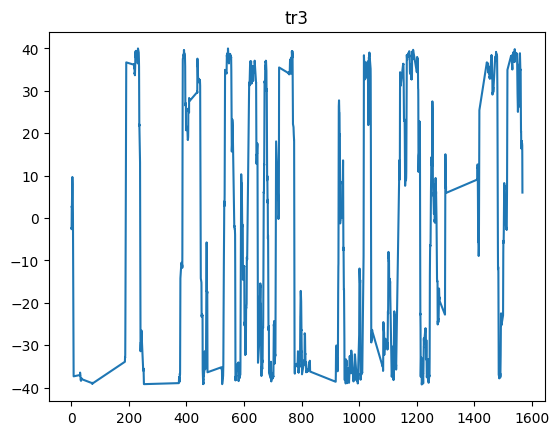

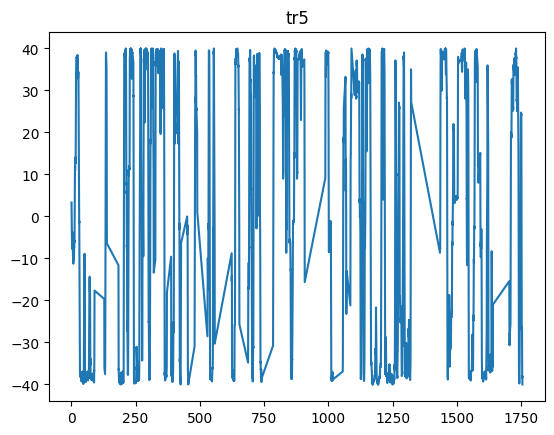

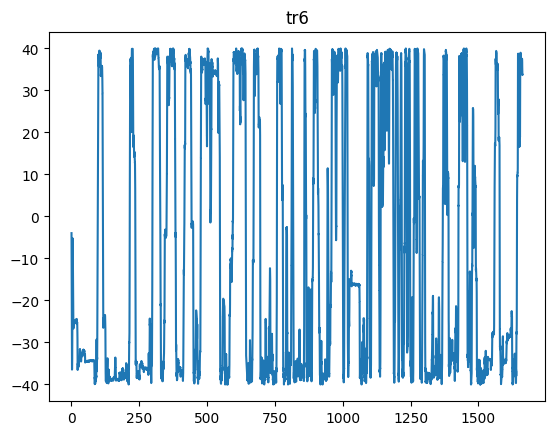

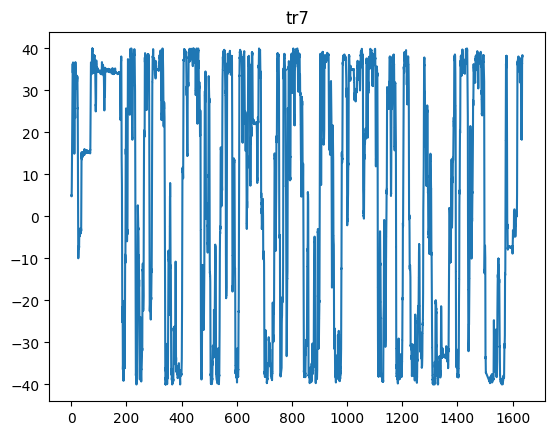

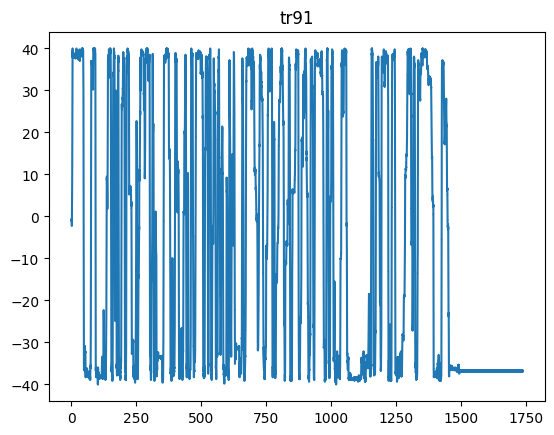

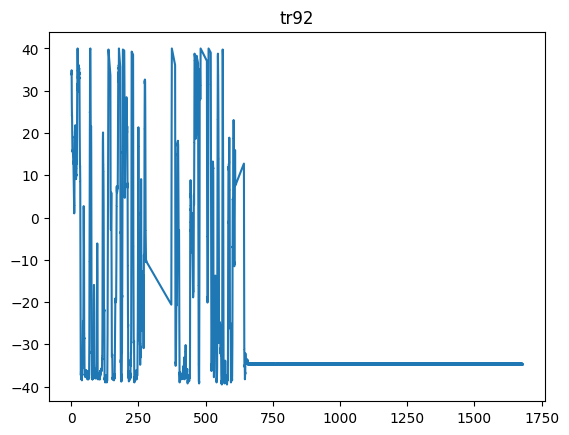

In [32]:
for i in ['tr3', 'tr5','tr6','tr7', 'tr91', 'tr92']:
    plt.plot(merg_dfs_dict[i]['time'], merg_dfs_dict[i]['x'])
    plt.title(i)
    plt.show()

In [113]:
#на вход нужна таблица с time x y 
# _1_ окууп карта меток dfHM
#блин бин х это y с тз траджа... ну аутпут беру верный. Хотя щас уже наоборот...

#parameter to change!!!!! n

def make_occup_map(marks_i, xmi=-40, xma=40, ymi=-40, yma=40, n=20):
    df = marks_i['df']
    binx = np.linspace(xmi, xma, n+1)
    #x_cut = pd.cut(df.X, binx, right=False)
    x_cut = pd.cut(df['x'], binx, right=False)

    biny = np.linspace(ymi, yma, n+1)
    #y_cut = pd.cut(df.Y, biny, right=False)
    y_cut = pd.cut(df['y'], biny, right=False)

    dfn = df.groupby([x_cut, y_cut]).count()
    
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    dfm = dfm.drop(columns=['x','y', 'green', 'blue'])
    dd = dfm.unstack()
    dd = dd.replace(0, 1.e-1)
    arrd = dd.to_numpy()
    arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    kk = (arrsrsr - np.amin(arrsrsr)) / (np.amax(arrsrsr) - np.amin(arrsrsr))
    kk = pd.DataFrame(kk)
    kk = kk.iloc[::-1]
    #kk = kk.iloc[:, ::-1]
    sns.heatmap(kk, square=True)
    #sns.heatmap(kk, square=True, xticklabels=False, yticklabels=False)
    return(kk, binx, biny)


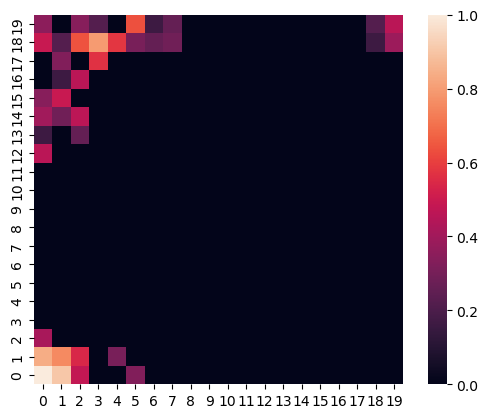

In [114]:
dfHM, biny, binx = make_occup_map(marks['tr7'])

In [115]:
# _2_ оккуп карта с индексами-координатами

binxmid = []
for i in range(len(binx)):
    if i != 0:
        binxmid.append((binx[i]+binx[i-1])/2)

binymid = []
for i in range(len(biny)):
    if i != 0:
        binymid.append((biny[i]+biny[i-1])/2)

dfHM.index = binxmid[::-1]
dfHM.columns = binymid

dfHM
        

,-38.0,-34.0,-30.0,-26.0,-22.0,-18.0,-14.0,-10.0,-6.0,-2.0,2.0,6.0,10.0,14.0,18.0,22.0,26.0,30.0,34.0,38.0
38.0,0.355072,0.000000,0.341136,0.221123,0.000000,0.634099,0.162367,0.257929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221123,0.457239
34.0,0.488714,0.221123,0.639334,0.794292,0.579544,0.307035,0.257929,0.285198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162367,0.389261
30.0,0.000000,0.325335,0.000000,0.566417,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
26.0,0.000000,0.162367,0.457239,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
22.0,0.341136,0.493327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
18.0,0.398842,0.285198,0.463015,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14.0,0.162367,0.000000,0.257929,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10.0,0.457239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


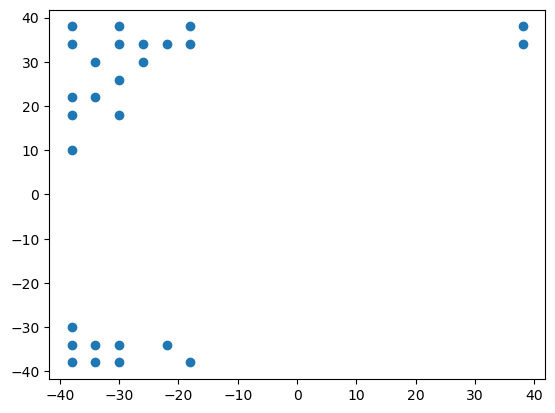

In [116]:
# _3_ вытащим координаты квадратов где довольно много меток
#координаты меток
#старое: т е i это y (row) а j это x (column)
#новое!! i это x (row) а j это y (column)
#parameter to change 0.3
tr7_coords = []
for i in range(dfHM.shape[0]-1, -1, -1):
    for j in range(dfHM.shape[1]):
        if dfHM.iloc[i, j] > 0.3:
            #print(dfHM.index[i], dfHM.columns[j])
            tr7_coords.append((dfHM.columns[j], dfHM.index[i]))
            



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_180\1764278431.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr7['r2'].iloc[i] += 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_180\1764278431.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr7['r1'].iloc[i] += 1


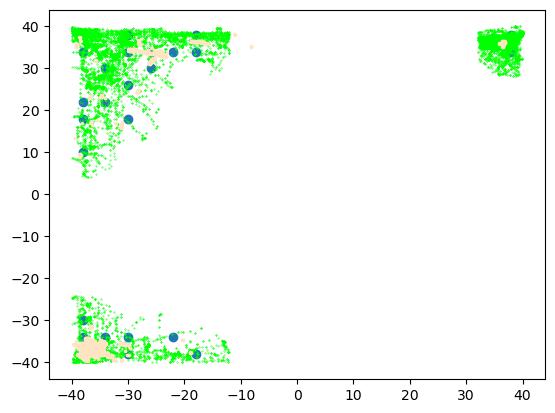

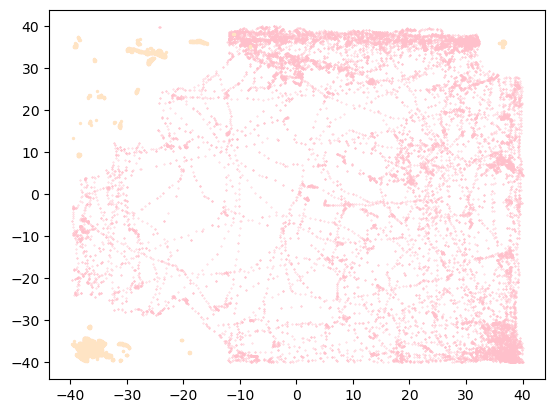

In [112]:
# _4_ для каждой точки определим, находится ли она в р1 р2 
r1 = 2
r2 = 3 * r1

tr7 = merg_dfs_dict['tr7']
tr7['r1'] = 0
tr7['r2'] = 0

for i in range(len(tr7)):
    for j in tr7_coords:
        if ((tr7['x'].iloc[i] - j[0]) ** 2) + ((tr7['y'].iloc[i] - j[1]) ** 2) < (r1 ** 2):
            tr7['r1'].iloc[i] += 1
        if ((tr7['x'].iloc[i] - j[0]) ** 2) + ((tr7['y'].iloc[i] - j[1]) ** 2) <= (r2 ** 2):
            tr7['r2'].iloc[i] += 1
            

check = tr7.loc[(tr7['r2']>0) & (tr7['r1']>=0)]
plt.scatter(check['x'], check['y'], s=0.1, c='lime')
plt.scatter(marks['tr7']['df']['y'],marks['tr7']['df']['x'],s=2, c='bisque')
plt.figure()
check1 = tr7.loc[(tr7['r2']==0) & (tr7['r1']==0)]
plt.scatter(check1['x'], check1['y'], s=0.1, c='pink')
plt.scatter(marks['tr7']['df']['y'],marks['tr7']['df']['x'],s=2, c='bisque')


In [ ]:
for i in ['tr91']:
    fig, ax = plt.subplots()
    plt.plot(merg_dfs_dict[i]['time'],merg_dfs_dict[i]['x'])
    plt.title(i)
    ax.set_xlim(1450, 1454)
    plt.show()